# Age and Gender Detection using CNN

**Objective** 

The primary goal of this article is to detect age and gender using the provided data set. We will detect age and gender using simple Python and Keras methods. Download the data set from AGE, GENDER, AND ETHNICITY (FACE DATA) CSV | Kaggle.


**Introduction**  

Picture processing is the process of improving image pictures taken from camera sources, satellites, airplanes, and images captured in everyday life. The image is processed using a variety of techniques and calculations based on the analysis. Digitally formed images must be carefully imagined and studied.

There are two main steps in image processing, followed by simple steps. Picture upgrades refer to the enhancement of an image with the end goal of producing more high-quality images that can be used by other programs. The other procedure is the most commonly used strategy for extracting data from a picture. Segmentation is the process of dividing an image into distinct parts.

The location of the information accessible in the images is critical. The image's information will be changed and adjusted for discovery purposes.

There are various procedures that must be followed, such as the removal of the issue. In a facial identification strategy, the articulations on the faces contain a wealth of information.

Several procedures are used to determine the age and gender of several faces. Features are extracted from the convolutional neural network. The image is processed into one of the age classes based on the prepared models.The highlights are handled further and shipped off the preparation frameworks.

**The Information**

In.csv format, the UTK Dataset contains age, gender, images, and pixels. For a long time, researchers have been interested in detecting age and gender based on images. To address this issue, various methodologies have taken control over the years. We will now begin with the task of recognizing age and gender using the Python programming language.

In [1]:
#Downloading streamlit
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library Imports 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

import cv2 as cv

In [3]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 347296.26it/s]


In [5]:
#Visualize data by pandas
image_paths = pd.Series(list(image_paths), name = 'Images Path')
age_labels = pd.Series(list(age_labels), name = 'Ages')
gender_labels = pd.Series(list(gender_labels), name = 'Genders')

df = pd.concat([image_paths, age_labels, gender_labels], axis = 1)
df.sample(10)

,Images Path,Ages,Genders
12689,../input/utkface-new/UTKFace/32_1_3_2017010417...,32,1
9474,../input/utkface-new/UTKFace/24_1_2_2017011617...,24,1
20033,../input/utkface-new/UTKFace/29_0_0_2017011712...,29,0
16139,../input/utkface-new/UTKFace/1_0_2_20161219204...,1,0
8396,../input/utkface-new/UTKFace/27_1_1_2017011716...,27,1
21331,../input/utkface-new/UTKFace/26_1_0_2017011715...,26,1
11066,../input/utkface-new/UTKFace/1_1_4_20161221193...,1,1
18890,../input/utkface-new/UTKFace/29_0_0_2017010516...,29,0
10411,../input/utkface-new/UTKFace/2_0_2_20161219142...,2,0
21603,../input/utkface-new/UTKFace/24_1_3_2017011915...,24,1


# Exploratory Data Analysis

In [6]:
df['Ages'].describe()

count    23708.000000
mean        33.303484
std         19.886112
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: Ages, dtype: float64

**Distribution plot of Image Ages**

[Text(0.5, 1.0, 'Age Density')]

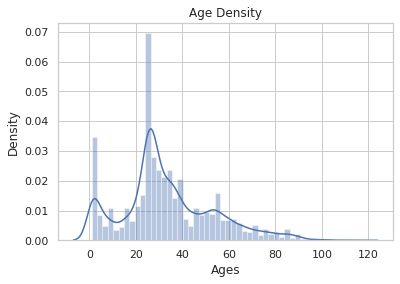

In [7]:
sns.set(style="whitegrid")
sns.distplot(df['Ages']).set(title = "Age Density")

**Gender Countplot**

For the genders, 0 represents male, 1 represents female


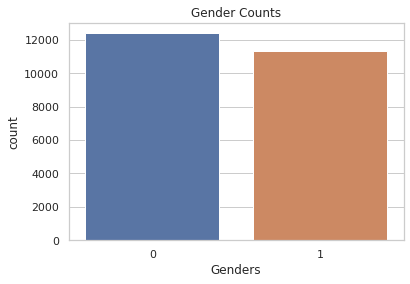

In [8]:
sns.set(style="whitegrid")
sns.countplot(df['Genders']).set(title = "Gender Counts")
print("For the genders, 0 represents male, 1 represents female")

**Gender Percentage**


<AxesSubplot:title={'center':'Gender Percentage of Images'}, ylabel='Genders'>

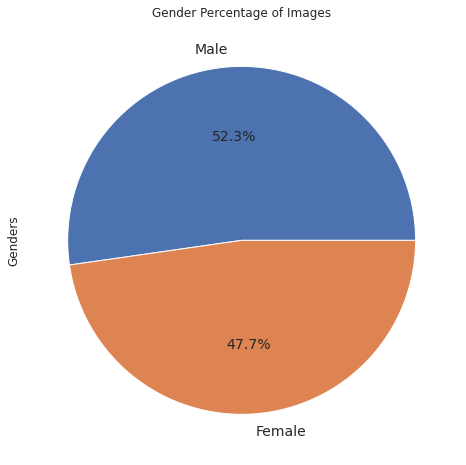

In [9]:
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(df['Genders'].replace(0,'Male').replace(1,'Female').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Gender Percentage of Images',y = 'Genders', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

**Age and Gender samples**

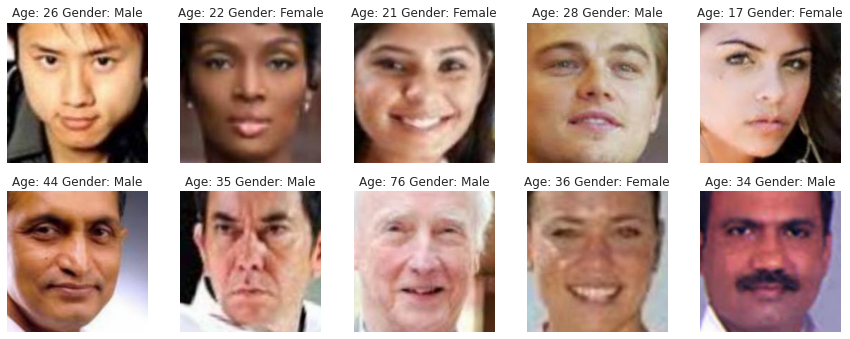

In [10]:
gender_dict = {0:'Male', 1:'Female'}

plt.figure(figsize=(15, 15))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# Feature Extraction



In [11]:

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=False)
        img = img.resize((64, 64), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 3)
    return features

In [12]:
X = extract_features(df['Images Path'])

100%|██████████| 23708/23708 [02:27<00:00, 160.49it/s]


In [13]:
#Normalize the images
X = X/255.0
y_gender = np.array(df['Genders'])
y_age = np.array(df['Ages'])

# Model Architecture and Design

In [14]:
from tensorflow.keras import Input, Model

input_shape = (64, 64, 3)

inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten_age = Flatten() (maxp_4)
flatten_gender = Flatten() (maxp_3)

# fully connected layers
dense_1 = Dense(128, activation='relu') (flatten_gender)
dense_2 = Dense(128, activation='relu') (flatten_age)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

2022-12-07 17:45:14.932557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:45:14.933486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:45:15.098192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:45:15.099099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:45:15.099973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

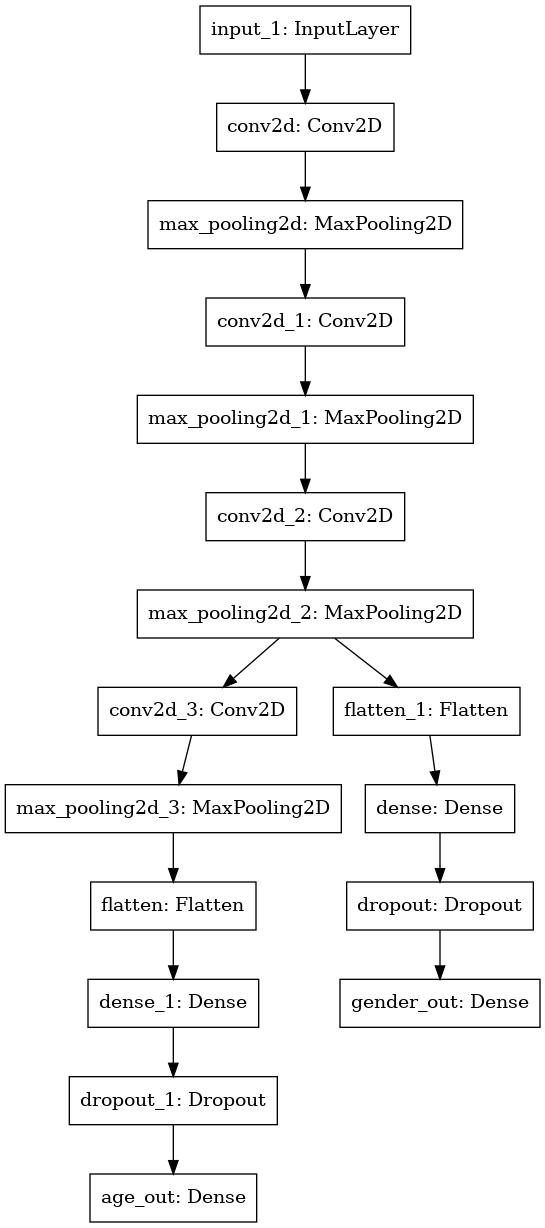

In [15]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [16]:
#Train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=50, validation_split=0.2)

2022-12-07 17:45:20.671506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 932216832 exceeds 10% of free system memory.
2022-12-07 17:45:21.825261: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 932216832 exceeds 10% of free system memory.
2022-12-07 17:45:22.590263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-07 17:45:24.768378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


593/593 [==============================] - 15s 10ms/step - loss: 15.8964 - gender_out_loss: 0.6612 - age_out_loss: 15.2352 - gender_out_accuracy: 0.5895 - age_out_accuracy: 0.0473 - val_loss: 12.5334 - val_gender_out_loss: 0.5403 - val_age_out_loss: 11.9932 - val_gender_out_accuracy: 0.7280 - val_age_out_accuracy: 0.0447
Epoch 2/50
593/593 [==============================] - 5s 8ms/step - loss: 11.9726 - gender_out_loss: 0.5099 - age_out_loss: 11.4627 - gender_out_accuracy: 0.7492 - age_out_accuracy: 0.0350 - val_loss: 11.0353 - val_gender_out_loss: 0.4287 - val_age_out_loss: 10.6066 - val_gender_out_accuracy: 0.8028 - val_age_out_accuracy: 0.0346
Epoch 3/50
593/593 [==============================] - 5s 8ms/step - loss: 10.3304 - gender_out_loss: 0.4221 - age_out_loss: 9.9082 - gender_out_accuracy: 0.8079 - age_out_accuracy: 0.0225 - val_loss: 9.6153 - val_gender_out_loss: 0.3752 - val_age_out_loss: 9.2401 - val_gender_out_accuracy: 0.8277 - val_age_out_accuracy: 0.0308
Epoch 4/50
593/5

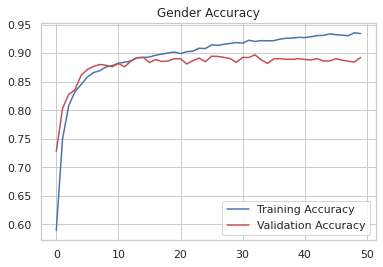

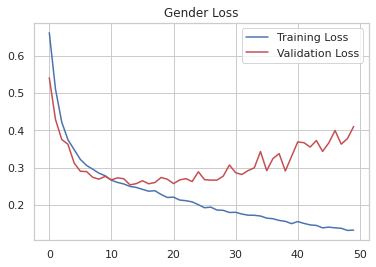

In [17]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Accuracy')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Loss')
plt.legend()
plt.show()

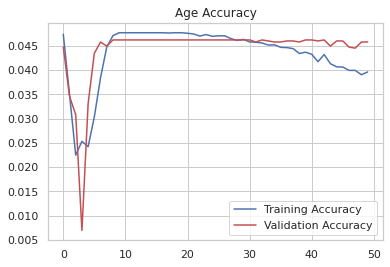

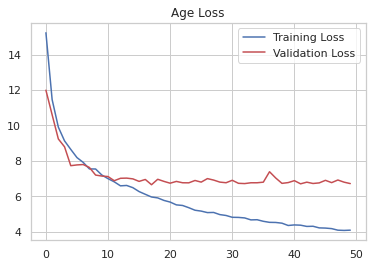

In [18]:
#Plot results for age
acc1 = history.history['age_out_accuracy']
val_acc1 = history.history['val_age_out_accuracy']
epochs = range(len(loss))

plt.plot(epochs, acc1, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc1, 'r', label='Validation Accuracy')
plt.title('Age Accuracy')
plt.legend()
plt.show()

loss1 = history.history['age_out_loss']
val_loss1 = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss1, 'b', label='Training Loss')
plt.plot(epochs, val_loss1, 'r', label='Validation Loss')
plt.title('Age Loss')
plt.legend()
plt.show()

# Results and Analysis

Original Gender: Male Original Age: 24
Predicted Gender: Male Predicted Age: 25


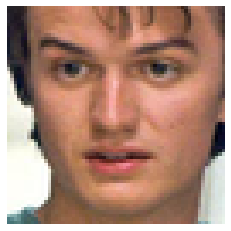

In [19]:
image_index = 430
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 64, 64, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index]);

In [20]:
def detect_image(image_index):
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  # predict from model
  pred = model.predict(X[image_index].reshape(1, 64, 64, 3))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(X[image_index]);

Original Gender: Male Original Age: 26
Predicted Gender: Male Predicted Age: 26
Original Gender: Female Original Age: 22
Predicted Gender: Female Predicted Age: 26
Original Gender: Female Original Age: 21
Predicted Gender: Female Predicted Age: 27
Original Gender: Male Original Age: 28
Predicted Gender: Male Predicted Age: 28
Original Gender: Female Original Age: 17
Predicted Gender: Female Predicted Age: 16
Original Gender: Male Original Age: 44
Predicted Gender: Male Predicted Age: 49
Original Gender: Male Original Age: 35
Predicted Gender: Male Predicted Age: 35
Original Gender: Male Original Age: 76
Predicted Gender: Male Predicted Age: 79
Original Gender: Female Original Age: 36
Predicted Gender: Female Predicted Age: 42
Original Gender: Male Original Age: 34
Predicted Gender: Male Predicted Age: 40


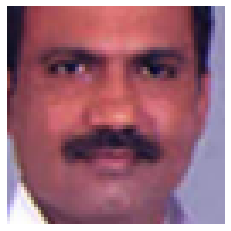

In [21]:
for i in range(10):
  detect_image(i)

In [22]:
model.save('Face_cnn.h5')

# Results and Conclusion

## Results

The model did fairly well with significant accuracy from the sample set. Out of a total of 10 samples, the gender prediction accuracy was 90% with the age prediction within a range of +/- 8 yrs 

## Conclusion

The task of recognizing age and gender is unquestionably difficult, more so than many other PC vision endeavors. The information required to prepare these types of frameworks is the fundamental justification for this trouble hole. While general article discovery tasks can frequently approach many thousands or even a large number of images for preparation, datasets with age and gender names are frequently in the thousands or, in the best case scenario, several thousand. Python obtained images, and the model did perform well in terms of the gender accuracy rate but not for the age prediction; further improvement in the model algorithm is required. One suggestion should be to incorporate more epochs which I presume would increase the accuracy.